In [11]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt


# set figure parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [12]:
# Overall settings
out_dir = "out"

model_name = "ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2.pt"
# model_name = "ckpt_50pct_recursive_h10_real_val_speed_correction_v2.pt"

current_path = os.getcwd().split("in-context-bldc")[0]
data_path = os.path.join(current_path,"in-context-bldc", "data")

folder = "CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia13_ki-0.0029-kp-3.0000"
# folder = "CL_experiments_double_sensor_high_speed_ekf_and_meta/final/inertia13_ki-0.0061-kp-11.8427"
folder_path = os.path.join(data_path, folder)

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/model_name, map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])
print(exp_data["cfg"])
print(exp_data["cfg"].lr)
print(exp_data["train_time"]/3600)


True
10
4931
0.00044166864245198667
Namespace(model_dir='out', out_file='ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2', in_file='ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2', init_from='scratch', seed=42, log_wandb=False, nx=4, nu=5, ny=1, seq_len=10, mag_range=(0.5, 0.97), phase_range=(0.0, 1.5707963267948966), fixed_system=False, n_layer=8, n_head=4, n_embd=16, dropout=0, bias=False, batch_size=128, max_iters=8000, warmup_iters=5000, lr=1e-05, weight_decay=0.0, eval_interval=10, eval_iters=10, fixed_lr=False, threads=16, no_cuda=False, cuda_device='cuda:0', compile=False, beta1=0.9, beta2=0.95, block_size=10, lr_decay_iters=8000, min_lr=1.0000000000000002e-06, decay_lr=True, eval_batch_size=128)
1e-05
4.3400412803226045


number of parameters: 0.03M


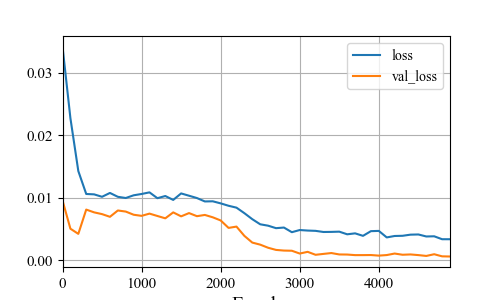

Model size in KB: 98.12890625


In [13]:
# generate the model
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)
# print(model.get_num_params())

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

#plot loss profile
plt.figure(figsize=(5,3))
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# compute model size
size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)

In [14]:
# plot the full trining loss profile, if the model reached the final iteration during training
try:
    model_name_check = model_name[:-3] + "_loss_check.pt"
    exp_data_check = torch.load(out_dir/model_name_check, map_location=device, weights_only=False)
    # print(model_name_check)
    print(exp_data_check["iter_num"])
    
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(exp_data_check['iter_num'])[::100], exp_data_check['LOSS'][::100], label="loss")
    plt.plot(np.arange(exp_data_check['iter_num'])[::100], exp_data_check['LOSS_VAL'][::100], label="val_loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
except:
    pass

In [15]:
# assemble the data


dfs = load_dataframes_from_folder(folder_path)
# Log the number of DataFrames loaded
print(f"Loaded {len(dfs)} DataFrames from {folder_path}.") 
H = exp_data["cfg"].seq_len # context window length
# Create an instance of the dataset
dataset_exp = Dataset(dfs=dfs, seq_len=H)
dataloader = DataLoader(dataset_exp, batch_size=exp_data["cfg"].batch_size, shuffle=True)


Loaded 15 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final/inertia13_ki-0.0029-kp-3.0000.


In [16]:
## test each experiment
df_len = len(dfs)
rmse = np.zeros(df_len)
u_full_all = []
y_full_all = []

# extract and stack all the experiments profiles
for i in range(df_len):
    u_full, y_full = dataset_exp.get_full_experiment(i)
    u_full, y_full = u_full.to(device), y_full.to(device)

    u_full_all.append(u_full)
    y_full_all.append(y_full)

u_full_all = torch.stack(u_full_all, dim=0)
y_full_all = torch.stack(y_full_all, dim=0)
y_pred_all = torch.zeros_like(y_full_all)

# generate the moving window of past estimations
last_omega = torch.zeros((df_len, H, 1)) 


with torch.no_grad():
    
    # j index moves aling the experiments time instants
    for j in range(y_full_all.shape[1]):
        
        # at time instant j
        # if the number of available samples < the context window, the model is fed only those samples
        if j < H:
            input_val = u_full_all[:, :j+1, :] # first j samples of the experiment
            input_val[:, :j+1, 4] = last_omega[:,-j-1:,0] # last j samples of the past estimations window

            pred = model(input_val)[:,-1,:] #we consider only the last value of the model estimation
        else:
            input_val = u_full_all[:,j-H+1:j+1, :]
            input_val[:,:, 4] = last_omega[:,:,0]

            pred = model(input_val)[:,-1,:] #we consider only the last value of the model estimation
        
        
        y_pred_all[:,j,0] = pred[:,0] # the list of estimations is updated
        last_omega = torch.roll(last_omega, -1, 1) # the window of last estimation is slid of 1 sample
        last_omega[:,-1,0] = y_pred_all[:,j,0] # last estimation is added to the window
        
    # input output and predictions are converted back to their original range of values
    u_full_all, y_full_all, y_pred_all  = reverse_normalization(u_full_all, y_full_all, y_pred_all)


In [17]:

# compute the rmse for each experiment, and produce its average
for i in range(df_len):
    y_tmp = y_full_all[i,:,:].cpu().numpy()
    y_pred_tmp = y_pred_all[i,:,:].cpu().numpy()
    rmse[i] = np.sqrt(((y_tmp-y_pred_tmp)**2).mean())

print("Average rmse: ", rmse.mean())


Average rmse:  34.61573053995768


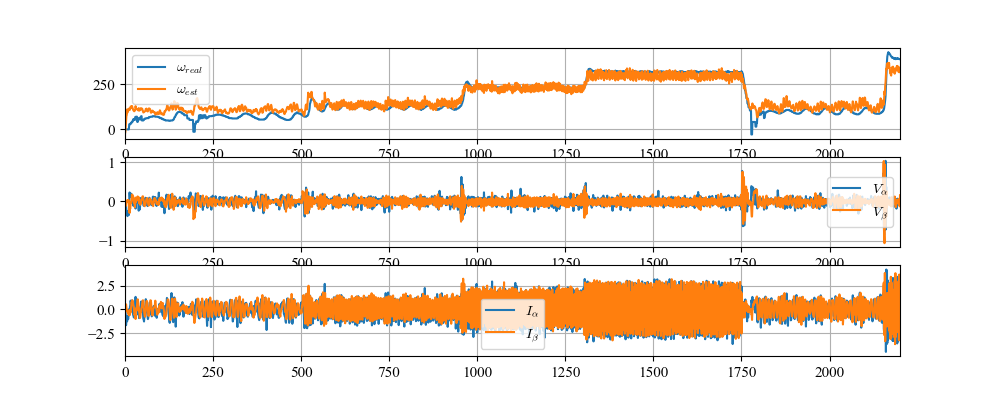

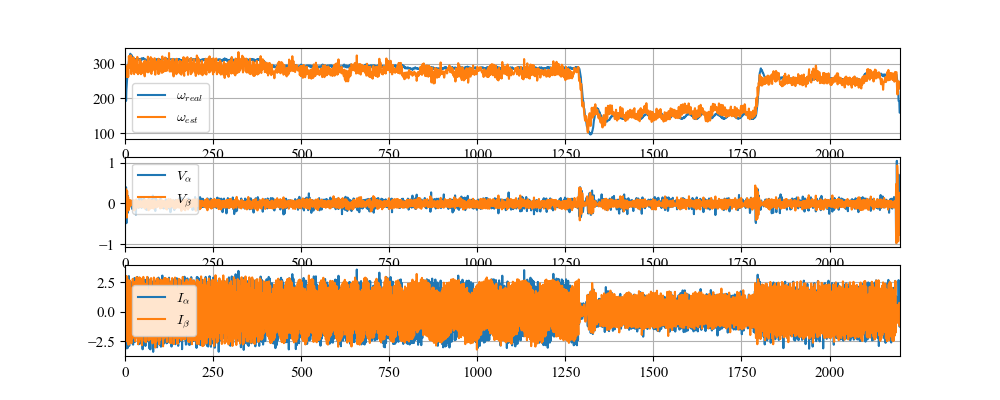

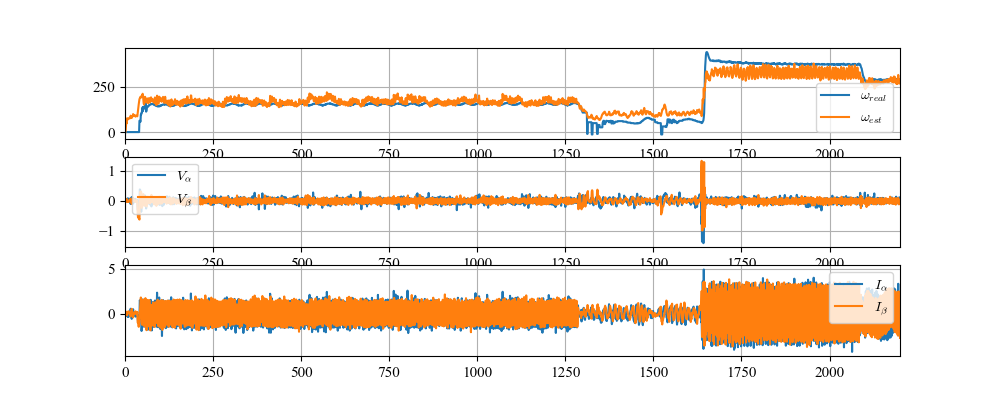

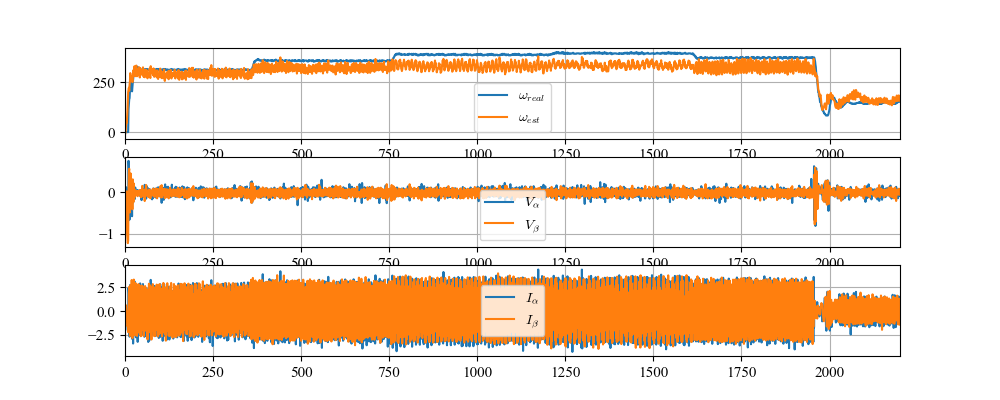

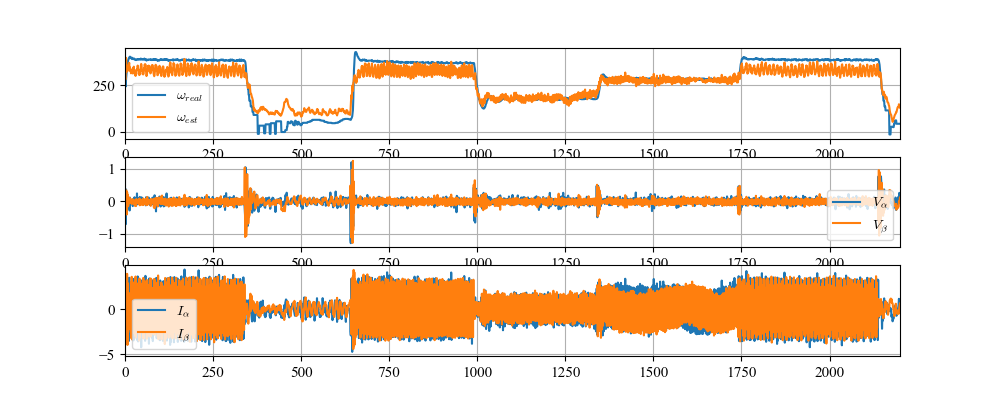

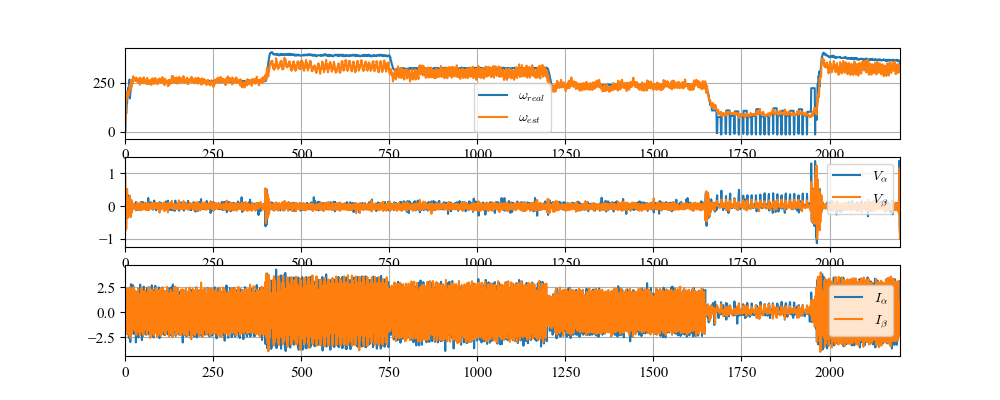

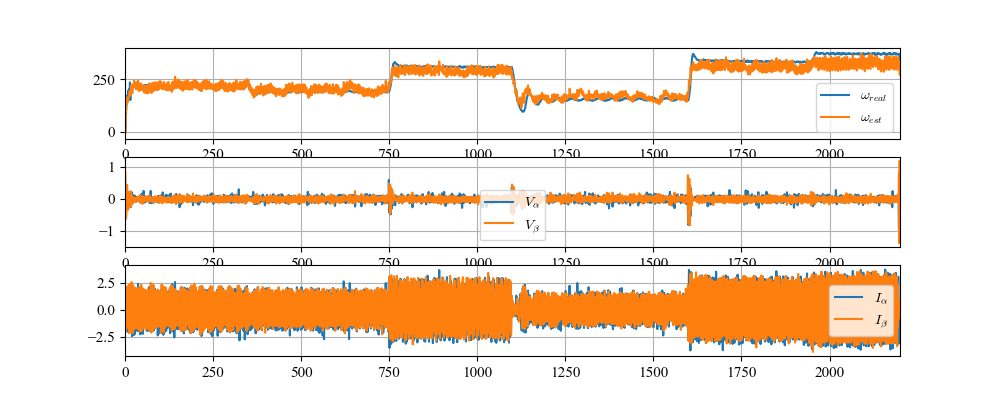

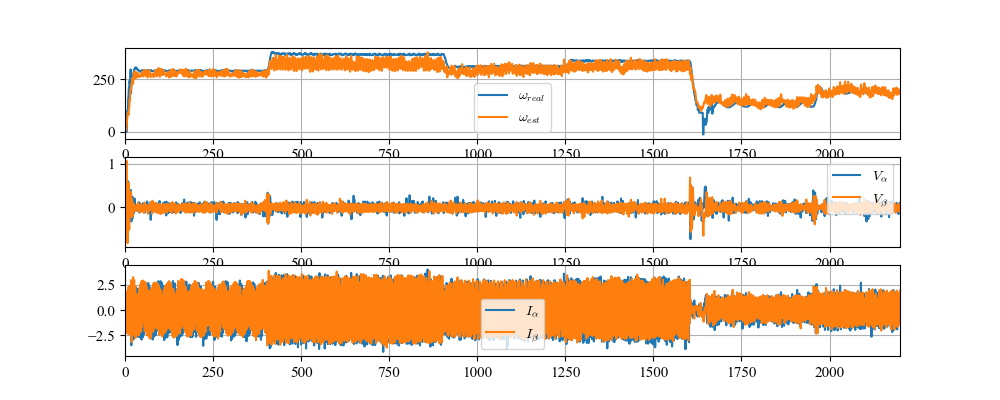

C:\Users\39340\AppData\Local\Temp\ipykernel_7544\3984529534.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,4))


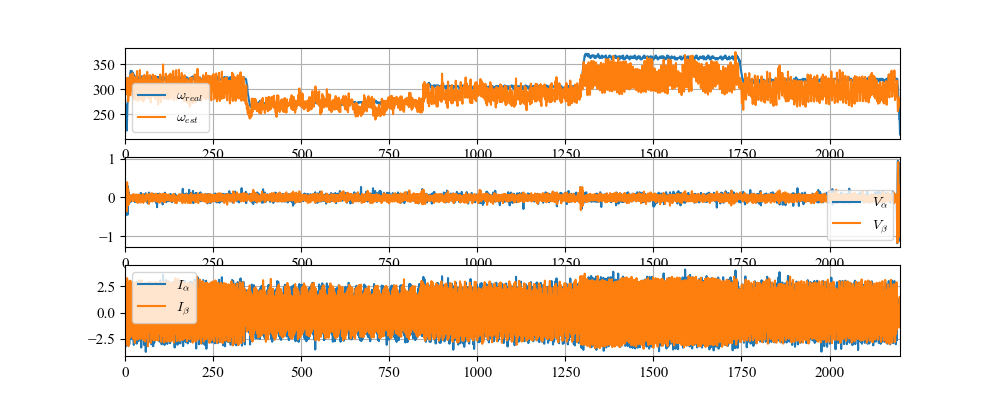

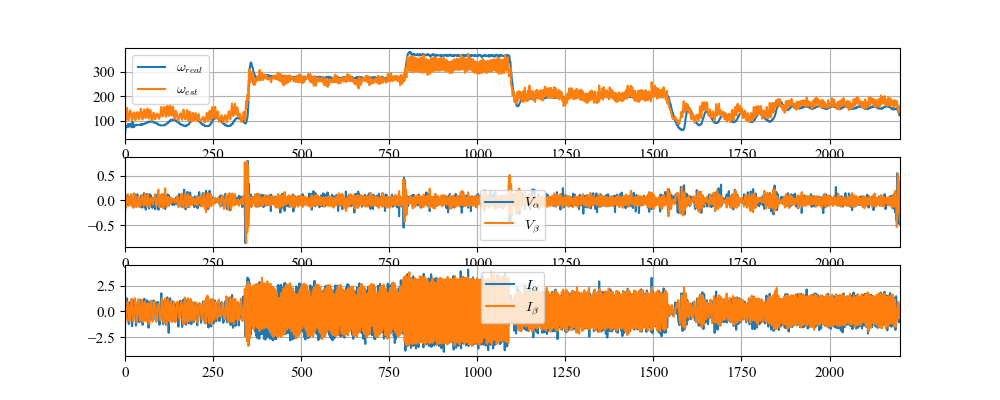

In [ ]:
# show the first 10 experiments
for i in range(10):

    y_full_np = y_full_all.cpu().numpy()
    y_pred_np = y_pred_all.cpu().numpy()
    u_full_np = u_full_all.cpu().numpy()

    # print(y_full_np.shape)
    # print(u_full_np.shape)
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(y_full_np[i])
    ax1.plot(y_pred_np[i])
    ax1.legend([r'$\omega_{real}$',r'$\omega_{est}$'])
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(u_full_np[i,:,0])
    ax2.plot(u_full_np[i,:,1])
    ax2.legend([r'$I_{\alpha}$',r'$I_{\beta}$'])
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(u_full_np[i,:,2])
    ax3.plot(u_full_np[i,:,3])
    ax3.legend([r'$V_{\alpha}$',r'$V_{\beta}$'])


    plt.show()
    